In [1]:
import pandas as pd

df = pd.read_csv("./data/augmented_processed.csv")

In [2]:
df

,task,url,title,test_set_id
0,Personal,https://mail.google.com/mail/u/0/#sent?compose...,Sent Mail - jeffpfaller@gmail.com - Gmail,user-6
1,Personal,https://docs.google.com/spreadsheets/d/1e5KWPU...,"Nov 4, 2024 New Hire Agenda - Google Sheets",user-6
2,Personal,https://calendar.google.com/calendar/u/0/r/week,"Google Calendar - Week of October 27, 2024",user-6
3,Personal,https://music.amazon.com/playlists/B07ZG3WKS8,Ambient Dreams Playlist on Amazon Music,user-6
4,Personal,https://travel.state.gov/content/travel/en/pas...,Apply for your First Passport as an Adult,user-6
...,...,...,...,...
783,Tech news (Ars Technica),https://arstechnica.com/information-technology...,Web performance benchmarks in 2025 - Ars Technica,user-domain-5
784,Tech news (Ars Technica),https://arstechnica.com/information-technology...,Security roundup: browser patches - Ars Technica,user-domain-5
785,Tech news (Hacker News mirrors),https://news.ycombinator.com/item?id=12345678,Ask HN: Best resources for large-scale system ...,user-domain-5
786,Tech news (Hacker News mirrors),https://news.ycombinator.com/item?id=23456789,Show HN: Minimal monitoring dashboard for side...,user-domain-5


In [4]:
# use onnx model to simulate firefox frontend as closely as possible
!pip install publicsuffix2

DEPRECATION: Loading egg at /Users/Vbaungally/anaconda3/lib/python3.11/site-packages/protobuf-3.20.1-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/Vbaungally/anaconda3/lib/python3.11/site-packages/fathom_web-3.7.3-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
"""
Smart Tab Grouping — Crossfold eval + Global (pooled-DEV) tuning + Final scores + PR curves + F1-vs-threshold

Features (all in [0,1]):
  - s_gc     : (cos(group name, candidate title) + 1) / 2
  - s_tt_max : max_j (cos(anchor title_j, candidate title) + 1) / 2
  - s_dd     : fraction of anchors whose base domain == candidate domain

Models:
  - Random baseline: Bernoulli(p) with p from pooled DEV positive rate
  - NN baseline: fixed threshold on s_tt_max
  - s_tt_max thr-only: single tuned threshold (on pooled DEV)
  - Logistic (with group): sigmoid(w·x+b), x=(s_gc, s_tt_max, s_dd)
  - Logistic (no group):  sigmoid(w·x+b), x=(s_tt_max, s_dd)
    * w is L1-normalized (∑|w_i| = 1) and w_i ≥ 0; bias, prob-threshold tuned

Splitting:
  - Per-user: split user’s groups into TRAIN vs TEST
  - Within TRAIN: create DEV with negatives; fallback to TRAIN2 if DEV empty
  - Anchors: up to MAX_ANCHORS per (user,group) block

Final selection:
  - Tune params on **pooled DEV across folds** (no TEST leakage)
  - Report **final TEST** scores using those single global params

Requires:
  pip install numpy pandas scikit-learn matplotlib seaborn
  pip install sentence-transformers
  (optional) pip install onnxruntime transformers optuna tldextract
"""

from __future__ import annotations

import os
import re
from typing import List, Dict, Any, Tuple, Optional

import numpy as np
import pandas as pd
from urllib.parse import urlparse
from sklearn.metrics import (
    f1_score,
    precision_recall_curve,
    average_precision_score,
)
import seaborn as sns

sns.set_theme()

# ---------- Optional plotting ----------
try:
    import matplotlib.pyplot as plt
    HAS_PLT = True
except Exception:
    HAS_PLT = False

# ---------- Optional Bayesian optimization ----------
try:
    import optuna
    HAS_OPTUNA = True
except Exception:
    HAS_OPTUNA = False

# ---------- ONNX + Tokenizer (optional) ----------
try:
    import onnxruntime as ort
    HAS_ORT = True
except Exception:
    HAS_ORT = False

try:
    from transformers import AutoTokenizer
    HAS_HF_TOKENIZER = True
except Exception:
    HAS_HF_TOKENIZER = False

# ---------- Optional tldextract for base domain ----------
try:
    import tldextract
    HAS_TLDEXTRACT = True
except Exception:
    HAS_TLDEXTRACT = False

# ---------- Columns ----------
COL_GROUP = "task"        # group label (string; can be empty)
COL_TITLE = "title"
COL_URL   = "url"
COL_USER  = "test_set_id" # user/window id

# ---------- Config ----------
MAX_ANCHORS   = 3          # typically 2–3 anchors (matches JS MAX_NN_GROUPED_TABS for LR)
SEED          = 42
N_FOLDS       = 5
TRAIN_FRAC    = 0.60       # per-user fraction of groups -> TRAIN
DEV_FRAC      = 0.20       # fraction of eligible groups -> DEV
DEV_MIN_GROUPS_PER_USER = 2
DEV_NEG_GROUP_RATIO     = 1.0
DEV_UNGROUP_FRAC        = 0.20
DEV_MIN_UNGROUP         = 1
NN_THRESHOLD  = 0.275       # fixed NN baseline threshold on s_tt_max (in [0,1])
N_TRIALS_BO   = 500
NORMALIZE_WEIGHTS = True   # L1-normalize weights
NONNEG_WEIGHTS   = True    # enforce w >= 0 for logistic

# --- Precision-weighted F-score config for analysis (F_beta) ---
F_BETA        = 0.5        # beta < 1 => more weight on precision in F_beta
PRECISION_TARGET = 0.85    # optional: "good suggestions" threshold for manual tuning

# --- Encoder selection (set ONNX path if you have a q8 model) ---
ONNX_MODEL_PATH       = "/Users/Vbaungally/Downloads/model_qint8_arm64.onnx"
TOKENIZER_ID_OR_DIR   = "sentence-transformers/all-MiniLM-L6-v2"
ONNX_PROVIDERS        = ("CPUExecutionProvider",)  # or ("CUDAExecutionProvider","CPUExecutionProvider")
MAX_LEN               = 128
BATCH_SIZE            = 256

rng_global = np.random.default_rng(SEED)

# -----------------------------
# Utilities
# -----------------------------

# Python port of SmartTabGroupingManager.preprocessText
# JS regex: const delimiters = /(?<=\s)[|–-]+(?=\s)/;
_TITLE_DELIMITERS_RE = re.compile(r"(?<=\s)[\|\u2013\-]+(?=\s)")


def preprocess_title(text: str) -> str:
    """
    Port of SmartTabGroupingManager.preprocessText from JS.

    - Splits on delimiters ('-', '|', '–') that are surrounded by spaces.
    - If there is enough information before the last chunk and the last chunk
      is "short" (< 20 chars), we drop the last chunk (assumed domain-ish).
    - Otherwise we return the original text.

    NOTE: This does *not* lowercase, matching the current JS behavior.
    """
    if text is None:
        return ""
    if not isinstance(text, str):
        text = str(text)

    if not text:
        return text

    parts = _TITLE_DELIMITERS_RE.split(text)
    if not parts:
        return text

    # JS:
    # const hasEnoughInfo =
    #   !!splitText.length && splitText.slice(0, -1).join(" ").length > 5;
    has_enough_info = len(parts) > 0 and len(" ".join(parts[:-1])) > 5

    # JS:
    # const isPotentialDomainInfo =
    #   splitText.length > 1 && splitText[splitText.length - 1].length < 20;
    is_potential_domain = len(parts) > 1 and len(parts[-1]) < 20

    if has_enough_info and is_potential_domain:
        cleaned = [p.strip() for p in parts[:-1]]
        cleaned = [p for p in cleaned if p]
        return " ".join(cleaned).strip()

    return text


def base_domain_from_url(spec: str) -> str:
    """
    Python port of SmartTabGroupingManager.getBaseDomain for logistic regression.

    Semantics:
      - Parse URL -> hostname
      - Normalize to lowercase, strip leading "www."
      - Use a PSL-based helper (tldextract) to get a registrable base domain
        when available (e.g. "google.com", "example.co.uk").
      - If host is just the base domain (or www.base) -> return base.
      - If there are extra subdomains -> return "lastSubdomain.baseDomain":
            docs.google.com           -> docs.google.com
            mail.google.co.uk         -> mail.google.co.uk
            foo.bar.baz.example.co.uk -> baz.example.co.uk

    Fallback when tldextract is missing or can't parse:
      - We just strip "www." and either return host, or "last two labels".
    """
    if not spec:
        return ""

    try:
        host = urlparse(spec).hostname or ""
    except Exception:
        return ""

    if not host:
        return ""

    lower_host = host.lower()
    host_no_www = re.sub(r"^www\.", "", lower_host)

    base_domain: Optional[str] = None

    if HAS_TLDEXTRACT:
        ext = tldextract.extract(lower_host)
        # ext.domain: "google", ext.suffix: "co.uk" -> "google.co.uk"
        if ext.domain and ext.suffix:
            base_domain = f"{ext.domain}.{ext.suffix}"
        elif ext.domain:
            # no recognized suffix: treat domain alone as base
            base_domain = ext.domain
        else:
            # localhost / IP / weird host -> bucket by hostNoWww
            return host_no_www
    else:
        # Fallback heuristic: behave like "last two labels" after stripping www.
        parts = host_no_www.split(".")
        if len(parts) >= 2:
            base_domain = ".".join(parts[-2:])
        else:
            return host_no_www

    # If it's exactly the registrable domain (with or without www), use that.
    if host_no_www == base_domain:
        return base_domain

    host_labels = host_no_www.split(".")
    base_labels = base_domain.split(".")

    # If something weird happens and we don't have more labels than the base,
    # just fall back to the baseDomain.
    if len(host_labels) <= len(base_labels):
        return base_domain

    # Keep *one* subdomain label + baseDomain.
    # e.g. hostLabels = ["docs","google","com"], baseLabels = ["google","com"]
    #   -> keep ["docs","google","com"] -> "docs.google.com"
    #
    # hostLabels = ["foo","bar","baz","example","co","uk"],
    # baseLabels  = ["example","co","uk"]
    #   -> keep ["baz","example","co","uk"] -> "baz.example.co.uk"
    keep = host_labels[-(len(base_labels) + 1):]
    return ".".join(keep)


# -----------------------------
# Encoders
# -----------------------------
class OnnxMiniLMEncoder:
    """ONNXRuntime encoder for MiniLM-like sentence embeddings (quantized or fp32)."""

    def __init__(
        self,
        onnx_model_path: str,
        tokenizer_id_or_dir: str = TOKENIZER_ID_OR_DIR,
        max_len: int = MAX_LEN,
        batch_size: int = BATCH_SIZE,
        providers: Tuple[str, ...] = ONNX_PROVIDERS,
    ):
        if not HAS_ORT:
            raise RuntimeError("onnxruntime not installed.")
        if not HAS_HF_TOKENIZER:
            raise RuntimeError("transformers not installed for tokenizer.")
        self.session = ort.InferenceSession(onnx_model_path, providers=list(providers))
        self.inputs = {i.name for i in self.session.get_inputs()}
        self.out_names = [o.name for o in self.session.get_outputs()]
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_id_or_dir, use_fast=True)
        self.max_len = max_len
        self.batch_size = batch_size
        # Detect output kind
        self.output_kind = None
        for name in self.out_names:
            low = name.lower()
            if "sentence_embedding" in low or "pooled" in low:
                self.output_kind = "pooled"
                self.pooled_name = name
                break
        if self.output_kind is None:
            self.output_kind = "hidden"
            cand = [n for n in self.out_names if "last_hidden_state" in n or "hidden" in n]
            self.hidden_name = cand[0] if cand else self.out_names[0]

    def _batchify(self, texts: List[str]):
        return self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_len,
            return_attention_mask=True,
            return_token_type_ids=False,
        )

    @staticmethod
    def _mean_pool(last_hidden: np.ndarray, attention_mask: np.ndarray) -> np.ndarray:
        mask = attention_mask.astype(np.float32)[..., None]  # (B,T,1)
        summed = (last_hidden * mask).sum(axis=1)  # (B,H)
        counts = np.clip(mask.sum(axis=1), 1e-9, None)  # (B,1)
        return summed / counts

    def encode(self, texts: List[str]) -> np.ndarray:
        if not texts:
            return np.zeros((0, 384), dtype=np.float32)
        all_vecs = []
        for i in range(0, len(texts), self.batch_size):
            sl = texts[i : i + self.batch_size]
            tok = self._batchify(sl)
            inp = {
                "input_ids": np.array(tok["input_ids"], dtype=np.int64),
                "attention_mask": np.array(tok["attention_mask"], dtype=np.int64),
            }
            if "token_type_ids" in self.inputs:
                tti = tok.get("token_type_ids")
                if tti is None:
                    tti = np.zeros_like(inp["input_ids"], dtype=np.int64)
                else:
                    tti = np.array(tti, dtype=np.int64)
                inp["token_type_ids"] = tti

            outs = self.session.run(None, inp)
            out_map = {name: val for name, val in zip(self.out_names, outs)}

            if self.output_kind == "pooled":
                vecs = out_map[self.pooled_name].astype(np.float32)
            else:
                hidden = out_map[self.hidden_name].astype(np.float32)  # (B,T,H)
                vecs = self._mean_pool(hidden, inp["attention_mask"])
            vecs /= (np.linalg.norm(vecs, axis=1, keepdims=True) + 1e-12)
            all_vecs.append(vecs.astype(np.float32))
        return np.vstack(all_vecs)


class STMiniLMEncoder:
    """Fallback encoder using sentence-transformers."""

    def __init__(
        self,
        model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
        batch_size: int = BATCH_SIZE,
    ):
        from sentence_transformers import SentenceTransformer

        self.model = SentenceTransformer(model_name)
        self.batch_size = batch_size

    def encode(self, texts: List[str]) -> np.ndarray:
        embs = self.model.encode(
            list(texts),
            batch_size=self.batch_size,
            show_progress_bar=False,
            normalize_embeddings=True,
        )
        embs = np.asarray(embs, dtype=np.float32)
        embs /= (np.linalg.norm(embs, axis=1, keepdims=True) + 1e-12)
        return embs


def make_encoder():
    if ONNX_MODEL_PATH and HAS_ORT and HAS_HF_TOKENIZER:
        print(f"[Encoder] ONNX: {ONNX_MODEL_PATH}")
        return OnnxMiniLMEncoder(
            ONNX_MODEL_PATH, TOKENIZER_ID_OR_DIR, MAX_LEN, BATCH_SIZE, ONNX_PROVIDERS
        )
    if ONNX_MODEL_PATH and (not HAS_ORT or not HAS_HF_TOKENIZER):
        print("[Encoder] ONNX requested but deps missing; falling back to sentence-transformers.")
    print("[Encoder] sentence-transformers backend")
    return STMiniLMEncoder()


# -----------------------------
# Splitting
# -----------------------------
def userwise_group_split(
    df: pd.DataFrame, train_frac: float = TRAIN_FRAC, seed: int = SEED
):
    df = df.copy()
    df[COL_GROUP] = df[COL_GROUP].fillna("").astype(str)
    users = df[COL_USER].unique().tolist()
    rng = np.random.default_rng(seed)
    train_idx, test_idx = [], []
    for u in users:
        sub = df[df[COL_USER] == u]
        grouped = sub[(sub[COL_GROUP] != "") & (~sub[COL_GROUP].str.startswith("Ungrouped-"))]
        ungrouped = sub[
            (sub[COL_GROUP] == "") | (sub[COL_GROUP].str.startswith("Ungrouped-"))
        ]
        groups = grouped[COL_GROUP].unique().tolist()
        rng.shuffle(groups)
        n_train = int(round(train_frac * len(groups)))
        train_groups = set(groups[:n_train])
        test_groups = set(groups[n_train:])
        train_idx.extend(
            grouped[grouped[COL_GROUP].isin(train_groups)].index.tolist()
        )
        test_idx.extend(grouped[grouped[COL_GROUP].isin(test_groups)].index.tolist())
        ug_idx = ungrouped.index.to_numpy()
        rng.shuffle(ug_idx)
        n_ug_train = int(round(train_frac * len(ug_idx)))
        train_idx.extend(ug_idx[:n_ug_train].tolist())
        test_idx.extend(ug_idx[n_ug_train:].tolist())
    return df.loc[sorted(set(train_idx))], df.loc[sorted(set(test_idx))]


def userwise_dev_split_from_train(
    df_train: pd.DataFrame,
    dev_frac: float = DEV_FRAC,
    seed: int = SEED,
    min_group_size: int = 2,
):
    rng = np.random.default_rng(seed)
    df = df_train.copy()
    df[COL_GROUP] = df[COL_GROUP].fillna("").astype(str)
    train2_idx, dev_idx = [], []
    for u in df[COL_USER].unique().tolist():
        sub = df[df[COL_USER] == u]
        grouped = sub[(sub[COL_GROUP] != "") & (~sub[COL_GROUP].str.startswith("Ungrouped-"))]
        ungrouped = sub[
            (sub[COL_GROUP] == "") | (sub[COL_GROUP].str.startswith("Ungrouped-"))
        ]
        groups_all = grouped[COL_GROUP].unique().tolist()
        cnts = grouped[COL_GROUP].value_counts()
        eligible = cnts[cnts >= min_group_size].index.tolist()
        pos_dev = []
        if eligible:
            rng.shuffle(eligible)
            n_pos = max(1, min(len(eligible), int(round(dev_frac * len(eligible)))))
            pos_dev = eligible[:n_pos]
        neg_pool = [g for g in groups_all if g not in pos_dev]
        n_neg = 0
        if len(pos_dev) >= 1:
            need = max(0, DEV_MIN_GROUPS_PER_USER - len(pos_dev))
            want = int(np.ceil(DEV_NEG_GROUP_RATIO * len(pos_dev)))
            n_neg = min(max(need, want), len(neg_pool))
        neg_dev = []
        if n_neg > 0 and neg_pool:
            rng.shuffle(neg_pool)
            neg_dev = neg_pool[:n_neg]
        if pos_dev or neg_dev:
            dev_set = set(pos_dev) | set(neg_dev)
            dev_idx.extend(
                grouped[grouped[COL_GROUP].isin(dev_set)].index.tolist()
            )
            train2_idx.extend(
                grouped[~grouped[COL_GROUP].isin(dev_set)].index.tolist()
            )
        else:
            train2_idx.extend(grouped.index.tolist())
        ug = ungrouped.index.to_numpy()
        if len(ug):
            rng.shuffle(ug)
            n_ug = int(round(DEV_UNGROUP_FRAC * len(ug)))
            if not neg_dev and len(pos_dev) >= 1:
                n_ug = max(DEV_MIN_UNGROUP, n_ug)
            n_ug = min(n_ug, len(ug))
            dev_idx.extend(ug[:n_ug].tolist())
            train2_idx.extend(ug[n_ug:].tolist())
    return df.loc[sorted(set(train2_idx))], df.loc[sorted(set(dev_idx))]


# -----------------------------
# Blocks & features
# -----------------------------
def build_blocks(
    df_subset: pd.DataFrame,
    title_embs_full: np.ndarray,
    group_embs_full: np.ndarray,
    idx_to_pos_full: Dict[Any, int],
) -> List[Dict[str, Any]]:
    """
    For each (user, group) with >=2 tabs:
      - anchors: up to MAX_ANCHORS (leave ≥1 positive)
      - candidates: all other user tabs in subset
      - features (all in [0,1]):
          s_gc     : (C_t · g_vec + 1)/2  [None if group title missing]
          s_tt_max : max_j (C_t · A_t[j] + 1)/2
          s_dd     : fraction of anchors with same base domain as candidate
      - skip blocks with all-positive or all-negative labels

    Titles are *already preprocessed* via preprocess_title before encoding,
    matching SmartTabGroupingManager.preprocessText in JS.
    """
    df = df_subset.copy()
    idx_list = df.index.tolist()
    idx_to_pos_sub = {idx: pos for pos, idx in enumerate(idx_list)}
    domains = df[COL_URL].map(base_domain_from_url).tolist()

    blocks: List[Dict[str, Any]] = []
    for user_id, df_u in df.groupby(COL_USER):
        # groups with at least 2 tabs
        eligible = [
            g for g, c in df_u[COL_GROUP].value_counts().items() if g and c >= 2
        ]
        for gname in eligible:
            g_idx = df_u.index[df_u[COL_GROUP] == gname].tolist()
            if len(g_idx) < 2:
                continue
            # leave at least 1 positive candidate
            k = min(MAX_ANCHORS, len(g_idx) - 1)
            if k < 1:
                continue
            anchors = g_idx[:k]
            cands = [i for i in df_u.index if i not in anchors]
            if not cands:
                continue

            # map to full positions for embeddings
            try:
                A_pos = [idx_to_pos_full[i] for i in anchors]
                C_pos = [idx_to_pos_full[i] for i in cands]
            except KeyError:
                continue
            A_t = title_embs_full[A_pos]  # (k,d)
            C_t = title_embs_full[C_pos]  # (n,d)

            # s_tt_max: max_j cos(anchor_j, cand) -> [-1,1] -> [0,1]
            sims = C_t @ A_t.T  # (n,k)
            s_tt_max = sims.max(axis=1).astype(np.float32)
            s_tt_max = 0.5 * (s_tt_max + 1.0)  # -> [0,1]

            # s_dd: fraction of anchors with same base domain as candidate
            try:
                anchor_domains = [domains[idx_to_pos_sub[i]] for i in anchors]
            except KeyError:
                continue

            def dom_of(idx_label):  # closure over domains and idx_to_pos_sub
                return domains[idx_to_pos_sub[idx_label]]

            s_dd = np.array(
                [
                    (
                        sum(
                            1 for ad in anchor_domains if ad and ad == dom_of(i)
                        )
                        / float(k)
                    )
                    if k > 0
                    else 0.0
                    for i in cands
                ],
                dtype=np.float32,
            )

            # s_gc (per candidate): cos(group, cand) -> [-1,1] -> [0,1]
            has_group_title = bool(str(gname).strip())
            if has_group_title:
                # group_embs_full is an encoding of COL_GROUP strings; same for all rows in group
                g_vec = group_embs_full[A_pos[0]]  # any row for this group
                s_gc = (C_t @ g_vec).astype(np.float32)
                s_gc = 0.5 * (s_gc + 1.0)  # -> [0,1]
            else:
                s_gc = None

            y = (df.loc[cands, COL_GROUP].values == gname).astype(int)
            pos = int(y.sum())
            if pos == 0 or pos == len(y):
                # skip degenerate blocks
                continue

            blocks.append(
                {
                    "user_id": user_id,
                    "group": gname,
                    "anchors": anchors,
                    "cands": cands,
                    "s_tt_max": s_tt_max,
                    "s_dd": s_dd,
                    "s_gc": s_gc,
                    "has_group_title": has_group_title,
                    "y": y.astype(int),
                }
            )
    return blocks


def clone_blocks_no_group(blocks: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    out = []
    for b in blocks:
        b2 = dict(b)
        b2["s_gc"] = None
        b2["has_group_title"] = False
        out.append(b2)
    return out


# -----------------------------
# Modeling utilities
# -----------------------------
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


def l1_normalize(w: np.ndarray) -> np.ndarray:
    if not NORMALIZE_WEIGHTS:
        return w
    s = float(np.sum(np.abs(w))) + 1e-12
    return (w / s).astype(np.float32)


def stack_Xy(
    blocks: List[Dict[str, Any]], with_group: bool, features: Tuple[str, ...]
):
    Xb, yb = [], []
    for b in blocks:
        if with_group and not b["has_group_title"]:
            continue
        if (not with_group) and b["has_group_title"]:
            continue
        cols = []
        for key in features:
            if key == "s_gc":
                if b["s_gc"] is None:
                    cols = None
                    break
                cols.append(b["s_gc"])
            elif key == "s_tt_max":
                cols.append(b["s_tt_max"])
            elif key == "s_dd":
                cols.append(b["s_dd"])
            else:
                raise ValueError(f"Unknown feature: {key}")
        if cols is None:
            continue
        X = np.column_stack(cols).astype(np.float32)
        Xb.append(X)
        yb.append(b["y"])
    return Xb, yb


def macro_from_preds(
    y_blocks: List[np.ndarray], yhat_blocks: List[np.ndarray]
) -> float:
    f1s = [
        f1_score(y, h, zero_division=0) for y, h in zip(y_blocks, yhat_blocks)
    ]
    return float(np.mean(f1s)) if f1s else 0.0


def micro_from_preds(
    y_blocks: List[np.ndarray], yhat_blocks: List[np.ndarray]
) -> float:
    if not y_blocks:
        return 0.0
    y_all = np.concatenate(y_blocks)
    h_all = np.concatenate(yhat_blocks)
    return f1_score(y_all, h_all, average="micro", zero_division=0)


# -----------------------------
# Models
# -----------------------------
def eval_nn_baseline(
    blocks: List[Dict[str, Any]], thr: float = NN_THRESHOLD
) -> Tuple[float, float]:
    """Threshold on s_tt_max only (s_tt_max in [0,1])."""
    yb, hb = [], []
    for b in blocks:
        y = b["y"]
        h = (b["s_tt_max"] >= thr).astype(int)
        yb.append(y)
        hb.append(h)
    return macro_from_preds(yb, hb), micro_from_preds(yb, hb)


def eval_random_baseline(
    blocks: List[Dict[str, Any]],
    p: Optional[float] = None,
    seed: int = SEED,
) -> Tuple[float, float, float]:
    """
    Random classifier: predict 1 with probability p (same p for all candidates).
    If p is None, estimate p from the positive rate of `blocks`.
    Returns (macro_f1, micro_f1, p_used).
    """
    if not blocks:
        if p is None:
            p = 0.5
        return np.nan, np.nan, float(p)

    y_blocks = [b["y"] for b in blocks]
    if p is None:
        y_all = np.concatenate(y_blocks)
        if y_all.size == 0:
            p = 0.5
        else:
            p = float(y_all.mean())
    rng = np.random.default_rng(seed)
    yhat_blocks = []
    for y in y_blocks:
        h = rng.binomial(1, p, size=len(y)).astype(int)
        yhat_blocks.append(h)
    macro = macro_from_preds(y_blocks, yhat_blocks)
    micro = micro_from_preds(y_blocks, yhat_blocks)
    return macro, micro, float(p)


def tune_thr_on_max(
    dev_blocks: List[Dict[str, Any]], t_grid=np.linspace(0, 1, 101)
) -> float:
    if not dev_blocks:
        return NN_THRESHOLD
    best_t, best = NN_THRESHOLD, -1.0
    for t in t_grid:
        yb, hb = [], []
        for b in dev_blocks:
            y = b["y"]
            h = (b["s_tt_max"] >= t).astype(int)
            yb.append(y)
            hb.append(h)
        m = macro_from_preds(yb, hb)
        if m > best:
            best, best_t = m, t
    return float(best_t)


def tune_logistic(
    dev_blocks: List[Dict[str, Any]],
    with_group: bool,
    features: Tuple[str, ...],
    n_trials: int = N_TRIALS_BO,
    seed: int = SEED,
) -> Tuple[np.ndarray, float, float]:
    """
    Tune logistic weights + bias + probability threshold on DEV
    to maximize macro-F1 across blocks (symmetric objective).

    Later, you can inspect PR / F1-vs-threshold curves and optionally
    choose a different operating threshold biased toward precision.
    """
    Xb, yb = stack_Xy(dev_blocks, with_group=with_group, features=features)
    if not Xb:
        dim = len(features)
        return np.zeros(dim, np.float32), 0.0, 0.5
    dim = len(features)
    bounds_w = [(0.0, 6.0)] * dim if NONNEG_WEIGHTS else [(-6.0, 6.0)] * dim
    bounds_b = (-4.0, 4.0)
    bounds_t = (0.05, 0.95)

    def score(ws, b, thr):
        w = l1_normalize(np.array(ws, np.float32))
        yb_, hb_ = [], []
        for X, y in zip(Xb, yb):
            p = sigmoid(X @ w + b)
            h = (p >= thr).astype(int)
            yb_.append(y)
            hb_.append(h)
        return macro_from_preds(yb_, hb_)

    if HAS_OPTUNA:
        def objective(trial):
            ws = [
                trial.suggest_float(f"w_{features[i]}", *bounds_w[i])
                for i in range(dim)
            ]
            b_ = trial.suggest_float("bias", *bounds_b)
            t_ = trial.suggest_float("thr", *bounds_t)
            return score(ws, b_, t_)

        study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=seed),
        )
        study.optimize(
            objective, n_trials=n_trials, n_jobs=1, show_progress_bar=False
        )
        bp = study.best_params
        w_raw = np.array(
            [bp[f"w_{features[i]}"] for i in range(dim)], np.float32
        )
        w = l1_normalize(w_raw)
        b = float(bp["bias"])
        t = float(bp["thr"])
    else:
        rng = np.random.default_rng(seed)
        best, best_ws, best_b, best_t = -1.0, None, None, None
        for _ in range(n_trials):
            ws = [rng.uniform(*bounds_w[i]) for i in range(dim)]
            b_ = rng.uniform(*bounds_b)
            t_ = rng.uniform(*bounds_t)
            s = score(ws, b_, t_)
            if s > best:
                best, best_ws, best_b, best_t = s, ws, b_, t_
        w = l1_normalize(
            np.array(best_ws, np.float32)
            if best_ws is not None
            else np.zeros(dim, np.float32)
        )
        b = float(best_b if best_b is not None else 0.0)
        t = float(best_t if best_t is not None else 0.5)
    return w, b, t


def eval_logistic(
    blocks: List[Dict[str, Any]],
    with_group: bool,
    features: Tuple[str, ...],
    w: np.ndarray,
    b: float,
    thr: float,
) -> Tuple[float, float]:
    Xb, yb = stack_Xy(blocks, with_group=with_group, features=features)
    if not Xb:
        return np.nan, np.nan
    y_pred_blocks = []
    w_norm = l1_normalize(np.asarray(w, dtype=np.float32))
    for X, y in zip(Xb, yb):
        p = sigmoid(X @ w_norm + b)
        h = (p >= thr).astype(int)
        y_pred_blocks.append(h)
    macro = macro_from_preds(yb, y_pred_blocks)
    micro = micro_from_preds(yb, y_pred_blocks)
    return macro, micro


def gather_scores_and_labels(
    blocks: List[Dict[str, Any]],
    with_group: bool,
    features: Tuple[str, ...],
    w: np.ndarray,
    b: float,
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Flatten (X, y) across blocks and compute logistic scores for all candidates.

    Returns:
        y_all  : (N,) ground-truth labels in {0,1}
        scores : (N,) predicted probabilities sigmoid(w·x + b)

    If there is no data (e.g. no matching blocks), returns (None, None).
    """
    Xb, yb = stack_Xy(blocks, with_group=with_group, features=features)
    if not Xb:
        return None, None

    X = np.vstack(Xb).astype(np.float32)
    y = np.concatenate(yb).astype(int)

    w_norm = l1_normalize(np.asarray(w, dtype=np.float32))
    scores = sigmoid(X @ w_norm + float(b))
    return y, scores


def compute_pr_and_f_scores(
    y: np.ndarray,
    scores: np.ndarray,
    beta: float = F_BETA,
    precision_target: Optional[float] = PRECISION_TARGET,
) -> Dict[str, Any]:
    """
    Compute precision–recall curve + F1 and F_beta vs threshold.

    Uses sklearn.precision_recall_curve which returns:
      precision (len = n_thr + 1)
      recall    (len = n_thr + 1)
      thresholds (len = n_thr)

    We align:
      thresholds[i] <-> precision[i+1], recall[i+1]
    and drop the first (precision[0], recall[0]) with no threshold.
    """
    if y is None or scores is None or len(y) == 0:
        return {}

    prec_full, rec_full, thr = precision_recall_curve(y, scores)
    ap = average_precision_score(y, scores)

    if thr is None or len(thr) == 0:
        return {
            "precision": prec_full,
            "recall": rec_full,
            "thresholds": thr,
            "ap": float(ap),
            "f1": None,
            "f_beta": None,
        }

    # Align lengths
    p = prec_full[1:]
    r = rec_full[1:]
    thresholds = thr
    eps = 1e-12

    f1 = 2 * p * r / (p + r + eps)

    beta2 = beta ** 2
    f_beta = (1 + beta2) * p * r / (beta2 * p + r + eps)

    # Best F1 and F_beta
    best_f1_idx = int(np.nanargmax(f1)) if f1.size else None
    best_f1_thr = float(thresholds[best_f1_idx]) if best_f1_idx is not None else None
    best_f1 = float(f1[best_f1_idx]) if best_f1_idx is not None else None

    best_fb_idx = int(np.nanargmax(f_beta)) if f_beta.size else None
    best_fb_thr = float(thresholds[best_fb_idx]) if best_fb_idx is not None else None
    best_fb = float(f_beta[best_fb_idx]) if best_fb_idx is not None else None

    # Optional: first threshold achieving precision >= precision_target
    thr_at_p = None
    metrics_at_p = None
    if precision_target is not None and p.size:
        mask = p >= precision_target
        if mask.any():
            idx_pt = int(np.where(mask)[0][0])  # smallest thr meeting precision target
            thr_at_p = float(thresholds[idx_pt])
            metrics_at_p = {
                "precision": float(p[idx_pt]),
                "recall": float(r[idx_pt]),
                "f1": float(f1[idx_pt]),
                "f_beta": float(f_beta[idx_pt]),
            }

    return {
        "precision": p,
        "recall": r,
        "thresholds": thresholds,
        "ap": float(ap),
        "f1": f1,
        "f_beta": f_beta,
        "best_f1_threshold": best_f1_thr,
        "best_f1": best_f1,
        "best_f_beta_threshold": best_fb_thr,
        "best_f_beta": best_fb,
        "precision_target": float(precision_target) if precision_target is not None else None,
        "threshold_at_precision_target": thr_at_p,
        "metrics_at_precision_target": metrics_at_p,
    }


# -----------------------------
# Crossfold evaluation with pooled-DEV tuning
# -----------------------------
def crossfold_eval_with_pooled_tuning(
    df_raw: pd.DataFrame,
    n_folds: int = N_FOLDS,
    train_frac: float = TRAIN_FRAC,
    nn_threshold: float = NN_THRESHOLD,
    n_trials: int = N_TRIALS_BO,
):
    df = df_raw.copy()
    for c in [COL_GROUP, COL_TITLE, COL_URL, COL_USER]:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")
    df[COL_GROUP] = df[COL_GROUP].fillna("").astype(str)
    df[COL_TITLE] = df[COL_TITLE].fillna("").astype(str)
    df[COL_URL] = df[COL_URL].fillna("").astype(str)
    df[COL_USER] = df[COL_USER].fillna("").astype(str)

    # Match Firefox runtime: apply SmartTabGroupingManager.preprocessText()
    # to titles before encoding.
    df["_title_preproc"] = df[COL_TITLE].map(preprocess_title)

    enc = make_encoder()
    # Title embeddings: preprocessed titles
    title_embs_full = enc.encode(df["_title_preproc"].tolist())
    # Group embeddings: raw group labels (JS also embeds groupLabel directly)
    group_embs_full = enc.encode(df[COL_GROUP].tolist())
    idx_to_pos_full = {idx: pos for pos, idx in enumerate(df.index.tolist())}

    # Collect per-fold results + blocks
    res_rows = []
    dev_blocks_all: List[Dict[str, Any]] = []
    test_blocks_all: List[Dict[str, Any]] = []
    train2_blocks_all: List[Dict[str, Any]] = []

    for fold in range(1, n_folds + 1):
        df_train, df_test = userwise_group_split(
            df, train_frac=train_frac, seed=SEED + fold * 11
        )
        df_train2, df_dev = userwise_dev_split_from_train(
            df_train, dev_frac=DEV_FRAC, seed=SEED + fold * 97
        )

        tr2_blocks = build_blocks(
            df_train2, title_embs_full, group_embs_full, idx_to_pos_full
        )
        dev_blocks = build_blocks(
            df_dev, title_embs_full, group_embs_full, idx_to_pos_full
        )
        te_blocks = build_blocks(
            df_test, title_embs_full, group_embs_full, idx_to_pos_full
        )

        # if DEV empty, fallback to TRAIN2 for per-fold sanity (we still pool DEV later)
        dev_blocks_eff = dev_blocks if dev_blocks else tr2_blocks

        # Baseline (fixed)
        macro_b, micro_b = eval_nn_baseline(te_blocks, thr=nn_threshold)

        # Thr-only (tune on this fold's DEV for reference; global tuning happens later)
        thr_star = tune_thr_on_max(dev_blocks_eff)
        macro_thr, micro_thr = eval_nn_baseline(te_blocks, thr=thr_star)

        res_rows.append(
            {
                "fold": fold,
                "macro_f1_baseline": macro_b,
                "micro_f1_baseline": micro_b,
                "thr_only_star": thr_star,
                "macro_f1_thr_only": macro_thr,
                "micro_f1_thr_only": micro_thr,
            }
        )

        # pool DEV/TEST/TRAIN2 blocks to tune globally later
        dev_blocks_all.extend(dev_blocks)
        test_blocks_all.extend(te_blocks)
        train2_blocks_all.extend(tr2_blocks)

    res_df = pd.DataFrame(res_rows)

    # --------- Global (pooled-DEV) tuning ---------
    pooled_dev = dev_blocks_all if dev_blocks_all else train2_blocks_all
    if not pooled_dev:
        raise RuntimeError("No DEV (or TRAIN2) blocks found for global tuning.")

    # Estimate positive rate for random baseline from pooled DEV
    ys_dev = [b["y"] for b in pooled_dev]
    if ys_dev:
        y_dev_all = np.concatenate(ys_dev)
        p_rand = float(y_dev_all.mean()) if y_dev_all.size else 0.5
    else:
        p_rand = 0.5

    # Global tune: thr-only on s_tt_max
    thr_global = tune_thr_on_max(pooled_dev)

    # Global tune: logistic with group
    feats_wg = ("s_gc", "s_tt_max", "s_dd")
    w_wg, b_wg, t_wg = tune_logistic(
        pooled_dev,
        with_group=True,
        features=feats_wg,
        n_trials=n_trials,
        seed=SEED + 777,
    )

    # Global tune: logistic no-group (simulate missing s_gc)
    pooled_dev_ng = clone_blocks_no_group(pooled_dev)
    feats_ng = ("s_tt_max", "s_dd")
    w_ng, b_ng, t_ng = tune_logistic(
        pooled_dev_ng,
        with_group=False,
        features=feats_ng,
        n_trials=n_trials,
        seed=SEED + 999,
    )

    # --------- Final scores on pooled TEST using single global params ---------
    macro_rand, micro_rand, p_used = eval_random_baseline(
        test_blocks_all,
        p=p_rand,
        seed=SEED + 1234,
    )

    macro_nn, micro_nn = eval_nn_baseline(test_blocks_all, thr=nn_threshold)
    macro_thr, micro_thr = eval_nn_baseline(test_blocks_all, thr=thr_global)
    macro_wg, micro_wg = eval_logistic(
        test_blocks_all,
        with_group=True,
        features=feats_wg,
        w=w_wg,
        b=b_wg,
        thr=t_wg,
    )
    test_blocks_all_ng = clone_blocks_no_group(test_blocks_all)
    macro_ng, micro_ng = eval_logistic(
        test_blocks_all_ng,
        with_group=False,
        features=feats_ng,
        w=w_ng,
        b=b_ng,
        thr=t_ng,
    )

    final_scores = pd.DataFrame(
        [
            {
                "model": "Random baseline (p from DEV)",
                "params": {"p": float(p_used)},
                "macro_f1": float(macro_rand),
                "micro_f1": float(micro_rand),
            },
            {
                "model": "NN baseline (fixed thr)",
                "params": {"thr": float(nn_threshold)},
                "macro_f1": float(macro_nn),
                "micro_f1": float(micro_nn),
            },
            {
                "model": "s_tt_max thr-only (global tuned)",
                "params": {"thr": float(thr_global)},
                "macro_f1": float(macro_thr),
                "micro_f1": float(micro_thr),
            },
            {
                "model": "Logistic WITH group (global tuned; thr from DEV F1)",
                "params": {
                    "w": list(map(float, l1_normalize(w_wg))),
                    "bias": float(b_wg),
                    "thr": float(t_wg),
                },
                "macro_f1": float(macro_wg),
                "micro_f1": float(micro_wg),
            },
            {
                "model": "Logistic NO group (global tuned; thr from DEV F1)",
                "params": {
                    "w": list(map(float, l1_normalize(w_ng))),
                    "bias": float(b_ng),
                    "thr": float(t_ng),
                },
                "macro_f1": float(macro_ng),
                "micro_f1": float(micro_ng),
            },
        ]
    )

    # --------- Precision–Recall + F1-vs-threshold for logistic models on pooled TEST ---------
    pr_curves: Dict[str, Any] = {}

    # Logistic WITH group name
    y_wg, scores_wg = gather_scores_and_labels(
        test_blocks_all,
        with_group=True,
        features=feats_wg,
        w=w_wg,
        b=b_wg,
    )
    if y_wg is not None:
        pr_curves["with_group"] = compute_pr_and_f_scores(
            y_wg, scores_wg, beta=F_BETA, precision_target=PRECISION_TARGET
        )
    else:
        pr_curves["with_group"] = None

    # Logistic NO group name
    y_ng, scores_ng = gather_scores_and_labels(
        test_blocks_all_ng,
        with_group=False,
        features=feats_ng,
        w=w_ng,
        b=b_ng,
    )
    if y_ng is not None:
        pr_curves["no_group"] = compute_pr_and_f_scores(
            y_ng, scores_ng, beta=F_BETA, precision_target=PRECISION_TARGET
        )
    else:
        pr_curves["no_group"] = None

    return res_df, final_scores, pr_curves


# -----------------------------
# Optional plots
# -----------------------------
def plot_fold_curves(res_df: pd.DataFrame):
    if not HAS_PLT:
        return
    fig, ax = plt.subplots()
    ax.plot(
        res_df["fold"],
        res_df["macro_f1_baseline"],
        marker="o",
        label="NN baseline",
    )
    ax.plot(
        res_df["fold"],
        res_df["macro_f1_thr_only"],
        marker="o",
        label="s_tt_max thr-only",
    )
    ax.set_xlabel("Fold")
    ax.set_ylabel("Macro F1")
    ax.set_title("Per-fold Macro F1")
    ax.legend()
    plt.tight_layout()
    plt.show()


def _add_value_labels(ax, y_vals):
    for i, v in enumerate(y_vals):
        ax.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=10)


def plot_final_scores(
    final_scores: pd.DataFrame,
    out_dir: str = ".",
    prefix: str = "final_scores",
    save_svg: bool = True,
    show: bool = True,
):
    """
    final_scores must have columns: ['model', 'macro_f1', 'micro_f1'].
    Example rows:
      model='Random baseline (p from DEV)', macro_f1=..., micro_f1=...
      model='NN baseline (fixed thr)', macro_f1=..., micro_f1=...
      model='s_tt_max thr-only (global tuned)', ...
      model='Logistic WITH group (global tuned)', ...
      model='Logistic NO group (global tuned)', ...
    """
    if not HAS_PLT:
        return None

    os.makedirs(out_dir, exist_ok=True)

    # x-axis labels/order
    models = final_scores["model"].tolist()
    x = list(range(len(models)))

    # Baseline (dashed horizontal lines): NN baseline if present, else first row
    try:
        base_row = final_scores.loc[
            final_scores["model"] == "NN baseline (fixed thr)"
        ].iloc[0]
        baseline_macro = float(base_row["macro_f1"])
        baseline_micro = float(base_row["micro_f1"])
    except Exception:
        baseline_macro = float(final_scores["macro_f1"].iloc[0])
        baseline_micro = float(final_scores["micro_f1"].iloc[0])

    # ------- Macro-F1 -------
    fig1, ax1 = plt.subplots()
    macro_vals = final_scores["macro_f1"].astype(float).tolist()
    ax1.bar(x, macro_vals)
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=15, ha="right")
    ax1.set_ylabel("Macro F1")
    ax1.set_title("Final Scores — Macro F1 by Model")
    ax1.axhline(baseline_macro, linestyle="--")
    _add_value_labels(ax1, macro_vals)
    fig1.tight_layout()
    png1 = os.path.join(out_dir, f"{prefix}_macro.png")
    fig1.savefig(png1, dpi=150)
    if save_svg:
        fig1.savefig(os.path.join(out_dir, f"{prefix}_macro.svg"))
    if show:
        plt.show()
    else:
        plt.close(fig1)

    # ------- Micro-F1 -------
    fig2, ax2 = plt.subplots()
    micro_vals = final_scores["micro_f1"].astype(float).tolist()
    ax2.bar(x, micro_vals)
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, rotation=15, ha="right")
    ax2.set_ylabel("Micro F1")
    ax2.set_title("Final Scores — Micro F1 by Model")
    ax2.axhline(baseline_micro, linestyle="--")
    _add_value_labels(ax2, micro_vals)
    fig2.tight_layout()
    png2 = os.path.join(out_dir, f"{prefix}_micro.png")
    fig2.savefig(png2, dpi=150)
    if save_svg:
        fig2.savefig(os.path.join(out_dir, f"{prefix}_micro.svg"))
    if show:
        plt.show()
    else:
        plt.close(fig2)

    return {"macro_png": png1, "micro_png": png2}


def plot_pr_curves(
    pr_curves: Dict[str, Any],
    out_dir: str = ".",
    prefix: str = "stg_pr_curves",
    save_svg: bool = True,
    show: bool = True,
):
    """
    Plot precision–recall curves for the logistic regression models
    (with group name and without), using the pooled TEST set.

    `pr_curves` should be the dict returned by crossfold_eval_with_pooled_tuning(...)[2].
    """
    if not HAS_PLT:
        return None
    if not pr_curves:
        return None

    os.makedirs(out_dir, exist_ok=True)

    fig, ax = plt.subplots()

    handles = []

    wg = pr_curves.get("with_group")
    if wg and wg.get("precision") is not None:
        h_wg, = ax.plot(
            wg["recall"],
            wg["precision"],
            label=f"Logistic WITH group (AP={wg['ap']:.3f})",
        )
        handles.append(h_wg)

    ng = pr_curves.get("no_group")
    if ng and ng.get("precision") is not None:
        h_ng, = ax.plot(
            ng["recall"],
            ng["precision"],
            linestyle="--",
            label=f"Logistic NO group (AP={ng['ap']:.3f})",
        )
        handles.append(h_ng)

    if not handles:
        plt.close(fig)
        return None

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision–Recall (pooled TEST)")
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.05)
    ax.legend()

    fig.tight_layout()
    png = os.path.join(out_dir, f"{prefix}.png")
    fig.savefig(png, dpi=150)

    svg = None
    if save_svg:
        svg = os.path.join(out_dir, f"{prefix}.svg")
        fig.savefig(svg)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return {"pr_png": png, "pr_svg": svg}


def plot_f1_vs_threshold(
    pr_curves: Dict[str, Any],
    out_dir: str = ".",
    prefix: str = "stg_f1_curves",
    save_svg: bool = True,
    show: bool = True,
):
    """
    Plot F1 and F_beta vs threshold for the logistic models,
    so you can visually pick operating thresholds.
    """
    if not HAS_PLT:
        return None
    if not pr_curves:
        return None

    os.makedirs(out_dir, exist_ok=True)

    fig, ax = plt.subplots()

    handles = []

    for key, label_prefix, style in [
        ("with_group", "WITH group", "-"),
        ("no_group", "NO group", "--"),
    ]:
        info = pr_curves.get(key)
        if not info or info.get("thresholds") is None or info.get("f1") is None:
            continue
        thr = info["thresholds"]
        f1 = info["f1"]
        f_beta = info["f_beta"]

        h_f1, = ax.plot(
            thr, f1, linestyle=style,
            label=f"{label_prefix} F1"
        )
        handles.append(h_f1)
        if f_beta is not None:
            h_fb, = ax.plot(
                thr, f_beta, linestyle=style, alpha=0.6,
                label=f"{label_prefix} F_beta (β={F_BETA})"
            )
            handles.append(h_fb)

    if not handles:
        plt.close(fig)
        return None

    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_title("F1 / F_beta vs Threshold (pooled TEST)")
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.05)
    ax.legend()

    fig.tight_layout()
    png = os.path.join(out_dir, f"{prefix}.png")
    fig.savefig(png, dpi=150)
    svg = None
    if save_svg:
        svg = os.path.join(out_dir, f"{prefix}.svg")
        fig.savefig(svg)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return {"f1_png": png, "f1_svg": svg}


# -----------------------------
# Main entry
# -----------------------------
def main(
    df: pd.DataFrame,
    n_folds: int = N_FOLDS,
    train_frac: float = TRAIN_FRAC,
    nn_threshold: float = NN_THRESHOLD,
    n_trials: int = N_TRIALS_BO,
):
    res_df, final_scores, pr_curves = crossfold_eval_with_pooled_tuning(
        df,
        n_folds=n_folds,
        train_frac=train_frac,
        nn_threshold=nn_threshold,
        n_trials=n_trials,
    )
    print("\nPer-fold reference (fixed + per-fold tuned thr-only):")
    print(res_df)
    print(
        "\nFinal scores using single global parameters "
        "(tuned on pooled DEV, evaluated on pooled TEST):"
    )
    print(final_scores)
    print("\nPR + F-score info for manual threshold tuning is in `pr_curves`.")
    return res_df, final_scores, pr_curves


"""
# save onnx q8 file locally somewhere:
#   https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/blob/main/onnx/model_qint8_arm64.onnx
# update the ONNX_MODEL_PATH below
"""
if __name__ == "__main__":
    ONNX_MODEL_PATH = "/Users/Vbaungally/Downloads/model_qint8_arm64.onnx"
    TOKENIZER_ID_OR_DIR = "sentence-transformers/all-MiniLM-L6-v2"  # or a local tokenizer dir
    # df must be defined before this call (e.g., df = pd.read_csv(...))
    res_df, final_scores, pr_curves = main(df)

    if HAS_PLT:
        try:
            plot_fold_curves(res_df)
            plot_final_scores(final_scores, out_dir=".", prefix="stg_final_scores")
            plot_pr_curves(pr_curves, out_dir=".", prefix="stg_pr_curves")
            plot_f1_vs_threshold(pr_curves, out_dir=".", prefix="stg_f1_curves")
        except Exception as e:
            print("Plotting error:", e)


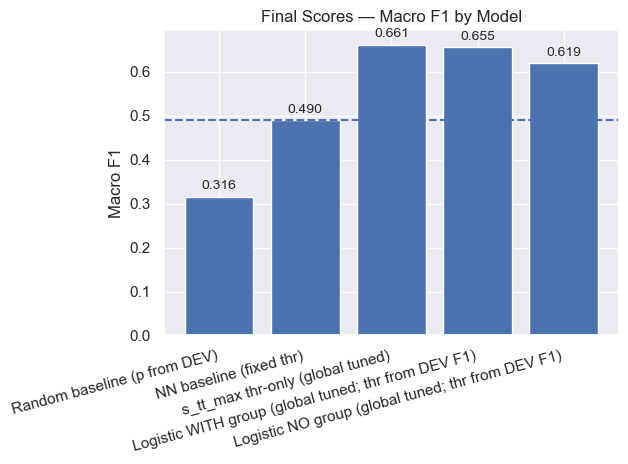

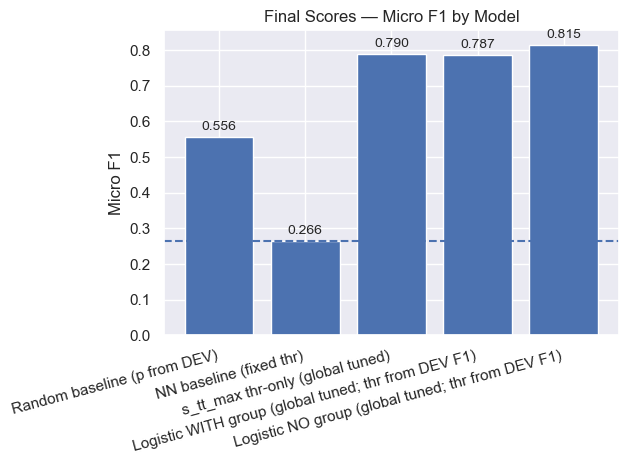

{'macro_png': './stg_final_scores_macro.png',
 'micro_png': './stg_final_scores_micro.png'}

In [82]:
plot_final_scores(final_scores, out_dir=".", prefix="stg_final_scores")

In [22]:
final_scores.loc[3]['params'], final_scores.loc[4]['params']

({'w': [0.10248799622058868, 0.5489689707756042, 0.34854307770729065],
  'bias': -0.07397235045536155,
  'thr': 0.5873219118383379},
 {'w': [0.9251306056976318, 0.07486938685178757],
  'bias': -2.585741561767855,
  'thr': 0.12233587182335684})

In [17]:
pr_curves["with_group"]

{'precision': array([0.26597383, 0.26617874, 0.26638396, ..., 0.625     , 0.        ,
        1.        ]),
 'recall': array([1.        , 1.        , 1.        , ..., 0.00723589, 0.        ,
        0.        ]),
 'thresholds': array([0.21576695, 0.21643074, 0.21681134, ..., 0.32671246, 0.32956865,
        0.33166084], dtype=float32),
 'ap': 0.5776201730301905,
 'f1': array([0.42018851, 0.42044417, 0.42070015, ..., 0.01430615, 0.        ,
        0.        ]),
 'f_beta': array([0.3117387 , 0.31196388, 0.31218939, ..., 0.03457815, 0.        ,
        0.        ]),
 'best_f1_threshold': 0.23859958350658417,
 'best_f1': 0.6743002544524335,
 'best_f_beta_threshold': 0.24058897793293,
 'best_f_beta': 0.6418139892383184,
 'precision_target': 0.85,
 'threshold_at_precision_target': 0.31006091833114624,
 'metrics_at_precision_target': {'precision': 0.8636363636363636,
  'recall': 0.027496382054992764,
  'f1': 0.05329593267876207,
  'f_beta': 0.12195121951169409}}

In [56]:
pr_curves["no_group"]

{'precision': array([0.26597383, 0.26607624, 0.26494408, ..., 1.        , 1.        ,
        1.        ]),
 'recall': array([1.        , 1.        , 0.99421129, ..., 0.00723589, 0.00144718,
        0.        ]),
 'thresholds': array([0.10294309, 0.10385285, 0.10408128, ..., 0.16305725, 0.16998388,
        0.1699839 ], dtype=float32),
 'ap': 0.6638616381941116,
 'f1': array([0.42018851, 0.4203163 , 0.4183922 , ..., 0.01436782, 0.00289017,
        0.        ]),
 'f_beta': array([0.3117387 , 0.31185125, 0.31049444, ..., 0.03516174, 0.00719424,
        0.        ]),
 'best_f1_threshold': 0.1221238374710083,
 'best_f1': 0.6572237960334946,
 'best_f_beta_threshold': 0.1258353739976883,
 'best_f_beta': 0.6757715501941794,
 'precision_target': 0.85,
 'threshold_at_precision_target': 0.1514466106891632,
 'metrics_at_precision_target': {'precision': 0.8775510204081632,
  'recall': 0.06222865412445731,
  'f1': 0.11621621621609254,
  'f_beta': 0.24239007891683942}}

In [51]:
final_scores

,model,params,macro_f1,micro_f1
0,Random baseline (p from DEV),{'p': 0.3909538737124944},0.315970,0.556154
1,NN baseline (fixed thr),{'thr': 0.275},0.489747,0.265769
2,s_tt_max thr-only (global tuned),{'thr': 0.63},0.661271,0.790000
3,Logistic WITH group (global tuned; thr from DE...,"{'w': [0.10248799622058868, 0.5489689707756042...",0.655385,0.786923
4,Logistic NO group (global tuned; thr from DEV F1),"{'w': [0.9251306056976318, 0.07486938685178757...",0.619366,0.814615
